# データ前処理

## インポート・設定

In [1]:
from pathlib import Path

import pandas as pd
import geopandas as gpd

In [2]:
DATA_DIR = Path("./data")
PROCESSED_DATA_DIR = Path("./data/processed")
PROCESSED_DATA_DIR.mkdir(exist_ok=True)

## 人口データ

### 読み込み

In [3]:
df_population = pd.read_csv(DATA_DIR / "population.csv")
df_population.head()

,表章項目,表章項目_階層,男女別,男女別_階層,人口,人口_階層,全国・都道府県,全国・都道府県_階層,時間軸（年）,時間軸（年）_階層,単位,値
0,人口,NaN,男女計,1,総人口,1,全国,1,2005年,1,千人,127768
1,人口,NaN,男女計,1,総人口,1,全国,1,2010年,1,千人,128057
2,人口,NaN,男女計,1,総人口,1,全国,1,2015年,1,千人,127095
3,人口,NaN,男女計,1,総人口,1,全国,1,2020年,1,千人,126146
4,人口,NaN,男女計,1,総人口,1,全国,1,2021年,1,千人,125502


### 前処理

In [4]:
def process_population(df_population: pd.DataFrame) -> pd.DataFrame:
    df = df_population.copy()

    # 全国のレコードを削除する
    df = df[~df["全国・都道府県"].eq("全国")].reset_index(drop=True)

    # 不要なカラムを削除する
    columns_to_drop = [
        "表章項目",
        "表章項目_階層",
        "男女別_階層",
        "人口_階層",
        "全国・都道府県_階層",
        "時間軸（年）_階層",
        "単位",
    ]
    df.drop(columns=columns_to_drop, inplace=True)

    # 扱いやすいようにカラム名を変更する
    column_mapper = {
        "男女別": "gender",
        "人口": "type",
        "全国・都道府県": "prefecture",
        "時間軸（年）": "year",
        "値": "population",
    }
    df = df.rename(columns=column_mapper)

    # データ型を変更する
    dtypes = {
        "gender": "category",
        "type": "category",
        "prefecture": "category",
        "year": "category",
        "population": "int",
    }
    df = df.astype(dtypes)

    return df

In [5]:
df_population_processed = process_population(df_population)
df_population_processed.info()
df_population_processed.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1974 entries, 0 to 1973
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   gender      1974 non-null   category
 1   type        1974 non-null   category
 2   prefecture  1974 non-null   category
 3   year        1974 non-null   category
 4   population  1974 non-null   int64   
dtypes: category(4), int64(1)
memory usage: 25.3 KB


,gender,type,prefecture,year,population
0,男女計,総人口,北海道,2005年,5628
1,男女計,総人口,北海道,2010年,5506
2,男女計,総人口,北海道,2015年,5382
3,男女計,総人口,北海道,2020年,5225
4,男女計,総人口,北海道,2021年,5183


### 書き出し

In [6]:
df_population_processed.to_pickle(PROCESSED_DATA_DIR / "df_population.pickle")

## 行政区画データ

### 読み込み

In [7]:
gdf_japan = gpd.read_file(DATA_DIR / "N03-23_230101.geojson")

In [8]:
gdf_japan.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 122929 entries, 0 to 122928
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   N03_001   122929 non-null  object  
 1   N03_002   9575 non-null    object  
 2   N03_003   51485 non-null   object  
 3   N03_004   122929 non-null  object  
 4   N03_007   122929 non-null  object  
 5   geometry  122929 non-null  geometry
dtypes: geometry(1), object(5)
memory usage: 5.6+ MB


In [9]:
gdf_japan.head(3)

,N03_001,N03_002,N03_003,N03_004,N03_007,geometry
0,北海道,石狩振興局,札幌市,札幌市中央区,01101,"POLYGON ((141.34233 43.06682, 141.34285 43.066..."
1,北海道,石狩振興局,札幌市,札幌市北区,01102,"POLYGON ((141.40839 43.18395, 141.40833 43.183..."
2,北海道,石狩振興局,札幌市,札幌市東区,01103,"POLYGON ((141.44707 43.15616, 141.44694 43.155..."


In [24]:
def process_geo_data(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    # 必要なカラムのみ残す
    columns_to_keep = ["N03_001", "geometry"]
    gdf = gdf[columns_to_keep]

    # 扱いやすいようにカラム名を変更する
    gdf = gdf.rename(columns={"N03_001": "prefecture"})

    # 都道府県単位にPolygonをまとめる
    gdf = gdf.dissolve(by="prefecture", as_index=False)

    return gdf

In [25]:
gdf_japan_processed = process_geo_data(gdf_japan)
gdf_japan_processed.info()
gdf_japan_processed.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   prefecture  47 non-null     object  
 1   geometry    47 non-null     geometry
dtypes: geometry(1), object(1)
memory usage: 884.0+ bytes


,prefecture,geometry
0,三重県,"MULTIPOLYGON (((136.02153 33.73432, 136.02155 ..."
1,京都府,"MULTIPOLYGON (((134.89366 35.64870, 134.89369 ..."
2,佐賀県,"MULTIPOLYGON (((129.78922 33.44450, 129.78926 ..."
3,兵庫県,"MULTIPOLYGON (((134.38285 34.71977, 134.38285 ..."
4,北海道,"MULTIPOLYGON (((139.34070 41.49478, 139.34066 ..."


試しにプロットしてみる

<Axes: >

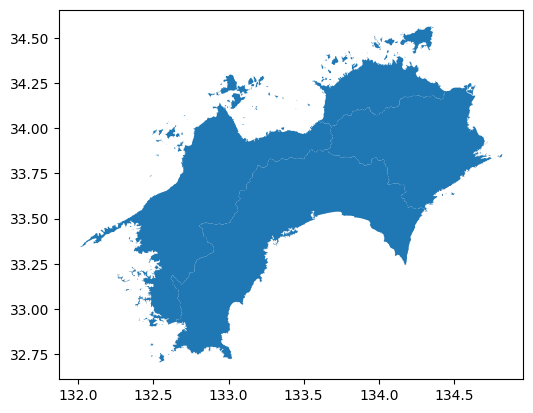

In [28]:
shikoku = ["愛媛県", "香川県", "徳島県", "高知県"]
gdf_japan_processed[gdf_japan_processed["prefecture"].isin(shikoku)].plot()

### 書き出し

In [29]:
gdf_japan_processed.to_file(
    PROCESSED_DATA_DIR / "prefectures.geojson", driver="GeoJSON"
)